In [1]:
import os
import shutil
import itertools
from collections import OrderedDict, Counter, defaultdict
import random
random.seed(123)

import torch
torch.manual_seed(123)
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
import matplotlib.pyplot as plt

import core.config as config
from core.utils import *

from chofer_tda_datasets import Animal
from chofer_tda_datasets.transforms import Hdf5GroupToDict


from torchph.nn.slayer import (
    SLayerExponential,
    SLayerRational,
    LinearRationalStretchedBirthLifeTimeCoordinateTransform,
    prepare_batch, 
    SLayerRationalHat
)

%matplotlib notebook

os.environ['CUDA_VISIBLE_DEVICES'] = "0" #str(1)


class train_env:
    nu = 0.01
    n_epochs = 10 # 200
    lr_initial = 0.01
    momentum = 0.9
    lr_epoch_step = 40
    batch_size = 100
    train_size = 0.9
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)
            

used_directions = ['dim_0_dir_{}'.format(i) for i in range(0, 32,2)]
dataset = Animal(root_dir=config.paths.data_root_dir)

Found data!


In [37]:
dataset[0]

({'dim_0_dir_0': array([[0.6617386 , 0.67436188],
         [0.26158052, 0.73874062]]),
  'dim_0_dir_1': array([[0.62453894, 0.65584191],
         [0.23256906, 0.81974766]]),
  'dim_0_dir_10': array([[0.2948799 , 0.44058038],
         [0.33270863, 0.34310179],
         [0.26892889, 0.81571513]]),
  'dim_0_dir_11': array([[0.34850975, 0.41530249],
         [0.35074772, 0.3845202 ],
         [0.25362314, 0.73532198]]),
  'dim_0_dir_12': array([[0.36739405, 0.39327948],
         [0.40756109, 0.43344652],
         [0.24778553, 0.64588553]]),
  'dim_0_dir_13': array([[0.36622634, 0.37709905],
         [0.47016481, 0.48632355],
         [0.25059555, 0.62643838]]),
  'dim_0_dir_14': array([[0.43660714, 0.45507276],
         [0.26299004, 0.66813803]]),
  'dim_0_dir_15': array([[0.34750079, 0.3964869 ],
         [0.28099107, 0.70540385]]),
  'dim_0_dir_16': array([[0.30417854, 0.35340934],
         [0.26125938, 0.73841948]]),
  'dim_0_dir_17': array([[0.32258464, 0.34153666],
         [0.1802523

In [2]:
dataset.data_transforms = [
    lambda x: {k: x[k] for k in used_directions}, 
    numpy_to_torch_cascade,
    lambda x: collection_cascade(x, 
        lambda x: isinstance(x, torch.Tensor), 
        lambda x: coordinate_transform(x)
                                )
]

In [39]:
dataset[0]

({'dim_0_dir_0': tensor([[0.6617, 0.0126],
          [0.2616, 0.4772]]),
  'dim_0_dir_2': tensor([[0.5826, 0.0603],
          [0.2084, 0.6801]]),
  'dim_0_dir_4': tensor([[0.4908, 0.1151],
          [0.1811, 0.7980]]),
  'dim_0_dir_6': tensor([[0.4004, 0.1543],
          [0.1713, 0.8261]]),
  'dim_0_dir_8': tensor([[0.3253, 0.1717],
          [0.2116, 0.7284]]),
  'dim_0_dir_10': tensor([[0.2949, 0.1457],
          [0.3327, 0.0104],
          [0.2689, 0.5468]]),
  'dim_0_dir_12': tensor([[0.3674, 0.0259],
          [0.4076, 0.0259],
          [0.2478, 0.3981]]),
  'dim_0_dir_14': tensor([[0.4366, 0.0185],
          [0.2630, 0.4051]]),
  'dim_0_dir_16': tensor([[0.3042, 0.0492],
          [0.2613, 0.4772]]),
  'dim_0_dir_18': tensor([[0.3095, 0.0146],
          [0.3274, 0.0121],
          [0.1115, 0.6801]]),
  'dim_0_dir_20': tensor([[0.2441, 0.0232],
          [0.0209, 0.7980]]),
  'dim_0_dir_22': tensor([[0.2170, 0.0290],
          [0.0026, 0.8261]]),
  'dim_0_dir_24': tensor([[0.2329

In [3]:
dgm = np.concatenate([x.numpy() for x in dataset[0][0].values()], axis=0)
print(np.shape(dgm))

(34, 2)


<IPython.core.display.Javascript object>


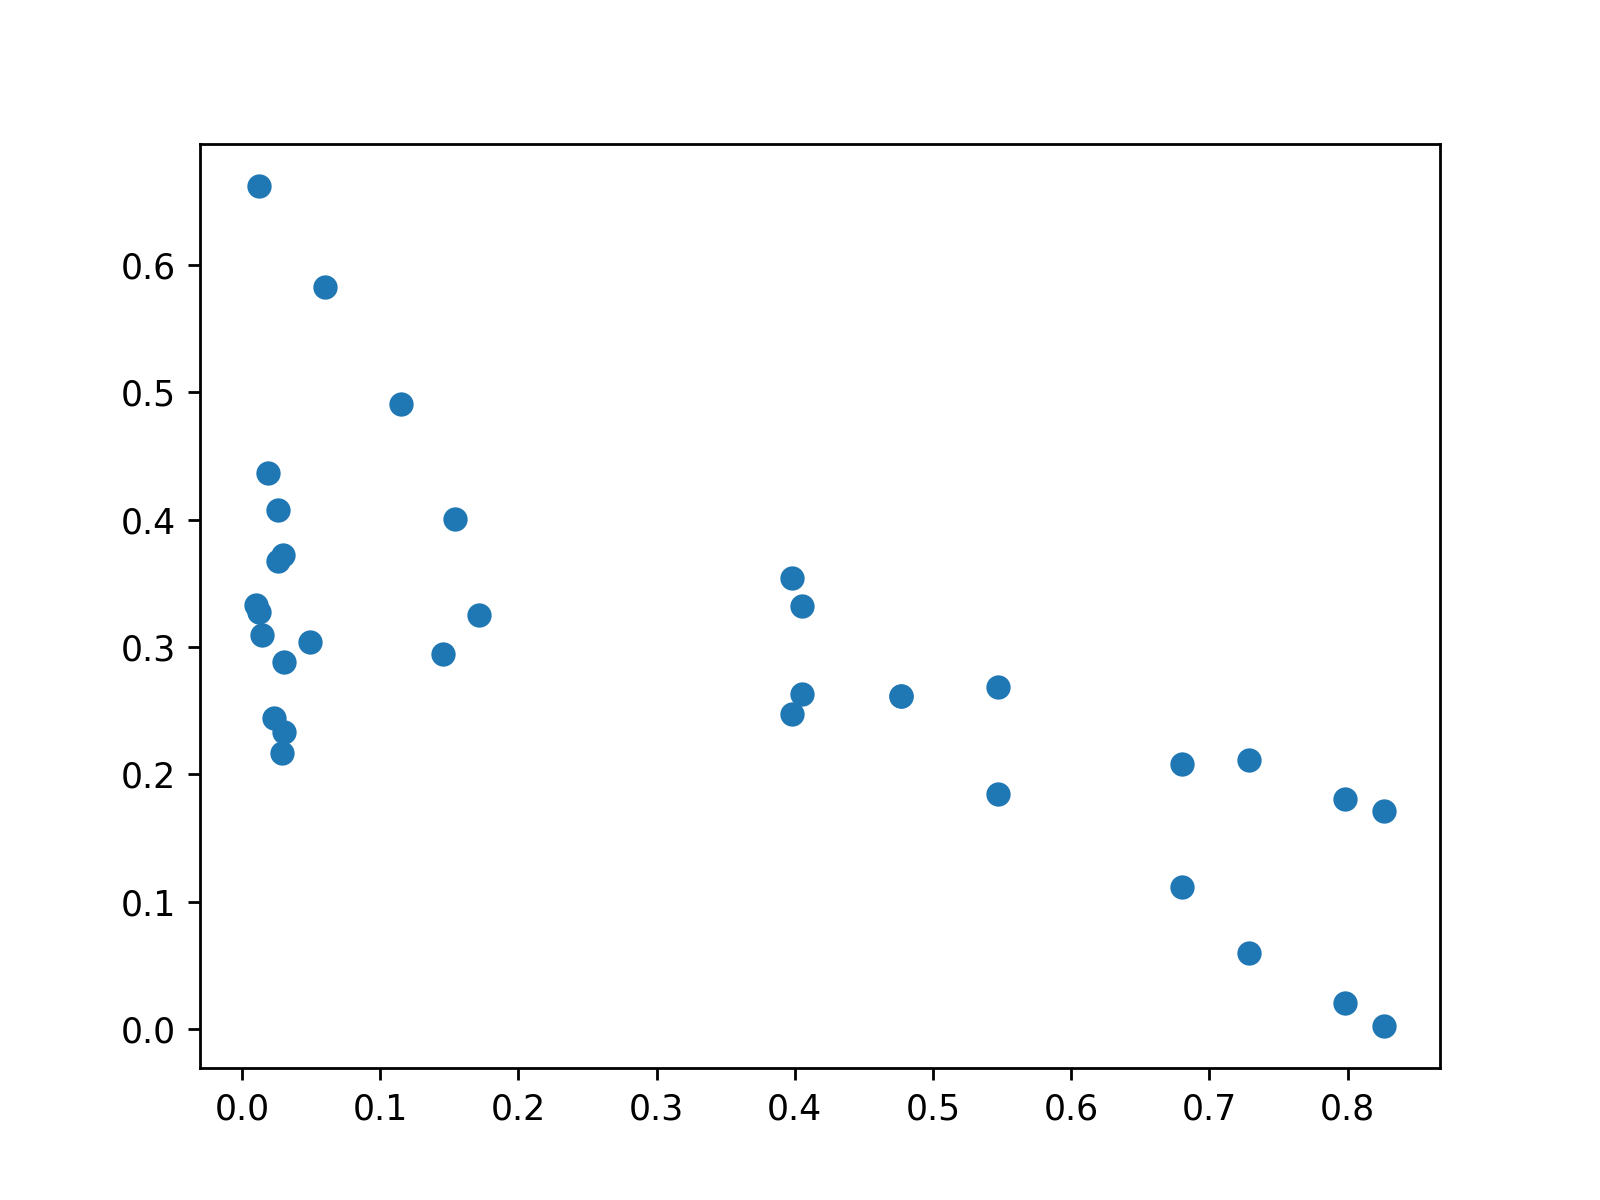

In [61]:
plt.figure()

plt.scatter(dgm[:,1], dgm[:,0])

plt.show()

<IPython.core.display.Javascript object>


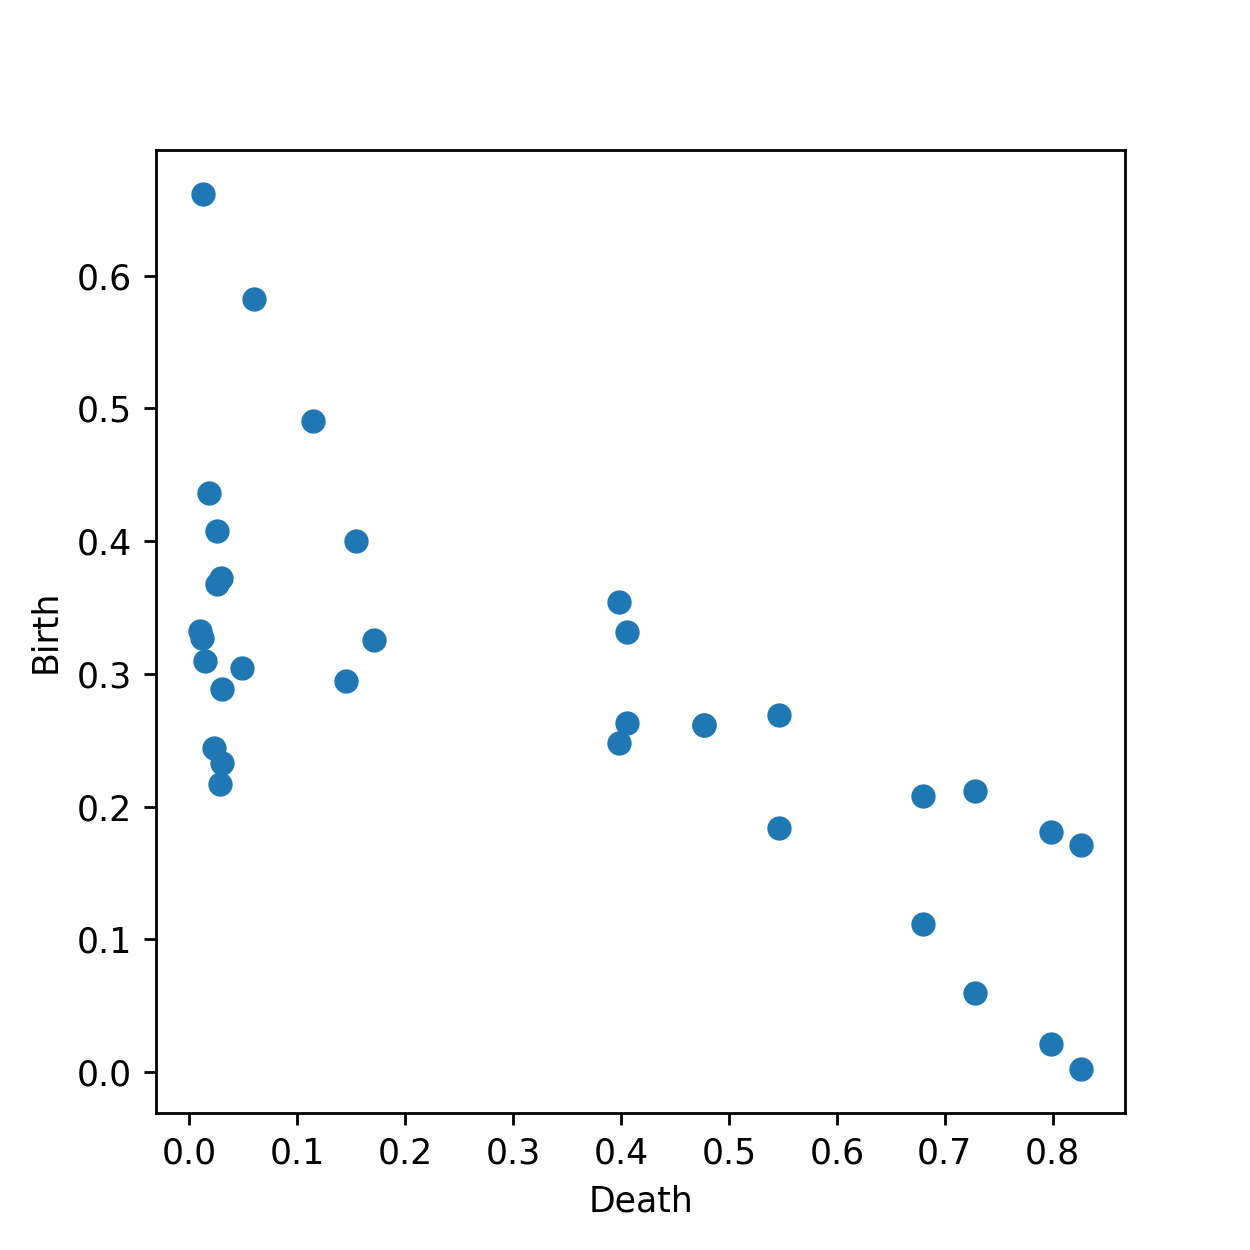

In [60]:
import math

def rotate(xy, radians):
    """Only rotate a point around the origin (0, 0)."""
    
    x, y = xy
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

dgm_r = np.zeros(np.shape(dgm))
PI = math.pi
for i in range(dgm_r.shape[0]):
#     dgm_r[i] = rotate(dgm[i], radians=2*PI-PI/4)
    dgm_r[i] = dgm[i]

# birth = (dgm_r[:,0] + dgm_r[:,1])/2
# death = (dgm_r[:,0] - dgm_r[:,1])/2

birth = dgm[:, 0]
death = dgm[:, 1]

plt.figure(figsize=(5,5))

plt.scatter(death, birth)
plt.xlabel("Death")
plt.ylabel("Birth")

plt.show()

In [4]:
class PHTCollate:   
    def __init__(self, nu, cuda=True, rotation_augmentation=False):
        self.cuda = cuda
        self.rotation_augmentation = rotation_augmentation
        
    def __call__(self, sample_target_iter):
        
        augmented_samples = []
        if self.rotation_augmentation:
            samples, targets = [], []
            for x, y in sample_target_iter:                
                i = random.randint(0, len(used_directions)-1)
                shifted_keys = used_directions[i:] + used_directions[:i]                
                
                samples.append({k: x[ki] for k, ki in zip(used_directions, shifted_keys)})
                targets.append(y)
                
            sample_target_iter = zip(samples, targets)

        x, y = dict_sample_target_iter_concat(sample_target_iter)                                            
                                              
        for k in x.keys():
            batch_view = x[k]
            x[k] = prepare_batch(batch_view, 2)                  

        y = torch.LongTensor(y)    

        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = {k: collection_cascade(v,
                                       lambda x: isinstance(x, tuple),
                                       lambda x: (x[0].cuda(), x[1].cuda(), x[2], x[3]))
                 for k, v in x.items()}

            y = y.cuda()

        return x, y                       
    
collate_fn = PHTCollate(train_env.nu, cuda=False)

In [5]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=0.25, exponent=1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class AnimalModel(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 100
        
        self.slayers = ModuleDict()
        for k in used_directions:
            s = Slayer(self.n_elements)
            self.slayers[k] = nn.Sequential(s)            
            
        cls_in_dim = len(used_directions)*self.n_elements
        self.cls = nn.Sequential(
                                nn.Dropout(0.3),
                                LinearCell(cls_in_dim, int(cls_in_dim/4)),    
                                nn.Dropout(0.2),
                                LinearCell(int(cls_in_dim/4), int(cls_in_dim/16)),  
                                nn.Dropout(0.1),
                                nn.Linear(int(cls_in_dim/16), 20))
        
    def forward(self, input):
        x = []
        for k in used_directions:            
            xx = self.slayers[k](input[k])
            x.append(xx)

        x = torch.cat(x, dim=1)          
        x = self.cls(x)       
                                              
        return x
    
    def center_init(self, sample_target_iter):
        centers = k_means_center_init(sample_target_iter, self.n_elements)
        
        for k, v in centers.items():
            self.slayers._modules[k][0].centers.data = v

In [7]:
from time import time

def experiment(train_slayer):    
    
    stats_of_runs = []
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)
    train_test_splits = list(splitter.split(X=dataset.labels, y=dataset.labels))
    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)     

        model = AnimalModel()
        model.center_init([dataset[i] for i in train_i])

        stats = defaultdict(list)
        stats_of_runs.append(stats)
        
        opt = torch.optim.SGD(model.parameters() if train_slayer else model.cls.parameters(), 
                              lr=train_env.lr_initial, 
                              momentum=train_env.momentum)
        
        t_start = time()
        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            dl_train = DataLoader(dataset,
                                  batch_size=train_env.batch_size, 
                                  collate_fn=collate_fn,
                                  sampler=SubsetRandomSampler(train_i))

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=SubsetRandomSampler(test_i))

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):              

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['dim_0_dir_0'][0].centers.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            
            for i_batch, (x, y) in enumerate(dl_test):

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y)).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            test_acc = true_samples.item()/seen_samples
            stats['test_accuracy'].append(test_acc)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
#             print('')
#             print(test_acc)
        
        t_end = time()
        duration = t_end - t_start
        print(f"duration {duration:.2f} sec")
        print('')
        print('acc.', np.mean(stats['test_accuracy'][-10:]))
        
    return stats_of_runs

In [8]:
res_learned_slayer = experiment(True)
accs = [np.mean(s['test_accuracy'][-10:]) for s in res_learned_slayer]
print(accs)
print(np.mean(accs))
print(np.std(accs))


Run 0
duration 86.33 sec 18/18       

acc. 0.5205

Run 1


KeyboardInterrupt: 

In [ ]:
res_rigid_slayer = experiment(False)
accs = [np.mean(s['test_accuracy'][-10:]) for s in res_rigid_slayer]
print(accs)
print(np.mean(accs))
print(np.std(accs))

In [ ]:
stats = res_learned_slayer[-1]
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()
